<a href="https://colab.research.google.com/github/bramvandeurzen934/Group16_ECG/blob/main/assignment_ecg_SVC_train_test_validate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template -- ECG data

## Data loading and exploration

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [27]:
# packages to import
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind
import numpy as np
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel, SelectKBest
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.metrics import make_scorer, f1_score

In [3]:
# Run this to use from colab environment
!git clone https://github.com/bramvandeurzen934/Group16_ECG.git

with zipfile.ZipFile('/content/Group16_ECG/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Group16_ECG')

data = pd.read_csv('/content/Group16_ECG/ecg_data.csv', index_col=0)

labels = data['label']
feature_data = data.drop('label',axis = 1)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'Group16_ECG' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


## Data exploration
Before further testing, data exploration will be performed, consisting of:

*   Class balance
*   Normal distribution
*   Missing data
*   Significantly differing features

### Class balance

In [ ]:
# Distribution of labels
print(f'In total, {list(labels).count(0)} ({round(list(labels).count(0)/len(labels)*100)}%) is labeled as normal and {list(labels).count(1)} ({round(list(labels).count(1)/len(labels)*100)}%) as abnormal')

In total, 681 (82%) is labeled as normal and 146 (18%) as abnormal


### Distribution

In [ ]:
# Parametric testing per class
#Defining two dataframes: one for each class
data_healthy = data[data["label"] == 0]
data_abnormal = data[data["label"] == 1]

data_healthy = data_healthy.drop('label',axis = 1)
data_abnormal = data_abnormal.drop('label',axis = 1)

n_parametric_healthy = 0
for columnname in data_healthy.columns:
  statistics = shapiro(list(data_healthy[columnname]))
  if statistics[1] > 0.05:
    n_parametric_healthy += 1

n_parametric_abnormal = 0
for columnname in data_abnormal.columns:
  statistics = shapiro(list(data_abnormal[columnname]))
  if statistics[1] > 0.05:
    n_parametric_abnormal += 1

print(f'''Healthy: {n_parametric_healthy} ({n_parametric_healthy/(data_healthy.shape[1])*100}%) features are normally distributed
Abnormal: {n_parametric_abnormal} ({n_parametric_abnormal/(data_abnormal.shape[1])*100}%) features are normally distributed''')


{}
{}


### Missing data

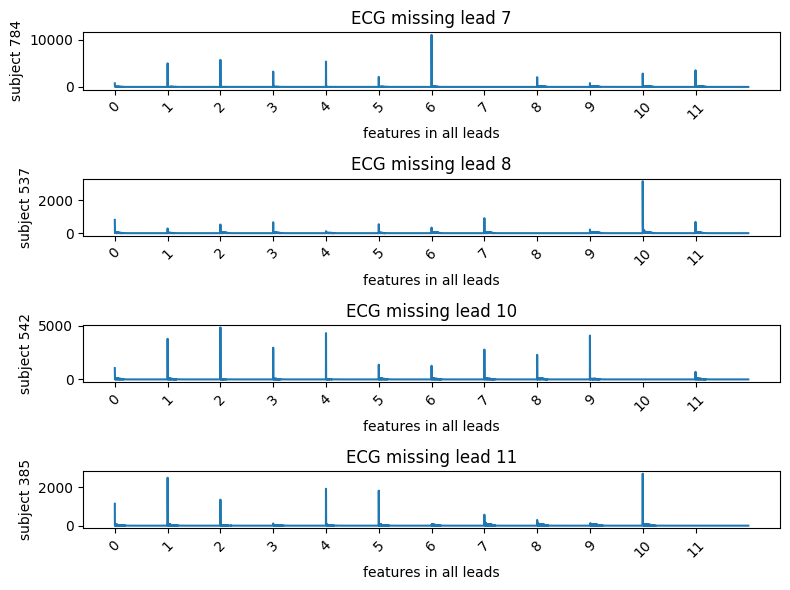

In [ ]:
# Missing data
list_zeros = []
for column in feature_data.columns:
  condition = feature_data.loc[data[column] == 0,column]
  if not len(condition) > 0:
    list_zeros.append(column)

print(f'A total of {len(list_zeros)} ({round(len(list_zeros)/feature_data.shape[1]*100,1)}%) features contain value 0 at least once.\n')

mask_data_zero = feature_data == 0

dict_mask_data_zero = {'n_missing_values': mask_data_zero.sum(1)}
df_persons_zero = pd.DataFrame(dict_mask_data_zero)
df_persons_zero["labels"] = labels

persons_missing_data = df_persons_zero[df_persons_zero['n_missing_values'] > 0]
print(f'''In total, {len(persons_missing_data)} persons have missing features, with a maximum of {persons_missing_data.max()[0]} features
{sum(persons_missing_data['labels'] == 0)} are of the class normal, whilst {sum(persons_missing_data['labels'] == 1)} are of the class abnormal''')



fig, axes = plt.subplots(4, 1, figsize=(8, 6))

sns.lineplot(x = data.columns,y=data.iloc[784,:],ax = axes[0])
sns.lineplot(x = data.columns,y=data.iloc[537,:],ax = axes[1])
sns.lineplot(x = data.columns,y=data.iloc[542,:],ax = axes[2])
sns.lineplot(x = data.columns,y=data.iloc[385,:],ax = axes[3])


axes[0].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[1].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[2].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[3].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)

axes[0].set(ylabel = 'subject 784',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 7')
axes[1].set(ylabel = 'subject 537',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 8')
axes[2].set(ylabel = 'subject 542',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 10')
axes[3].set(ylabel = 'subject 385',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 11')

plt.tight_layout()

plt.show()

The plot shows several examples of missing data. You can see that those examples exactly miss the full recordings of one ECG lead. Besides, it should be noted that different features contain different values, thus normalisation should be performed

### Significantly differing features
A two tailed T-test is performed on the data per feature. The test will find if there is a significant difference between the normal and abnormal ECG per feature. The features are sorted based on the p-value. The five most distinctive features are shown in the pairplot.

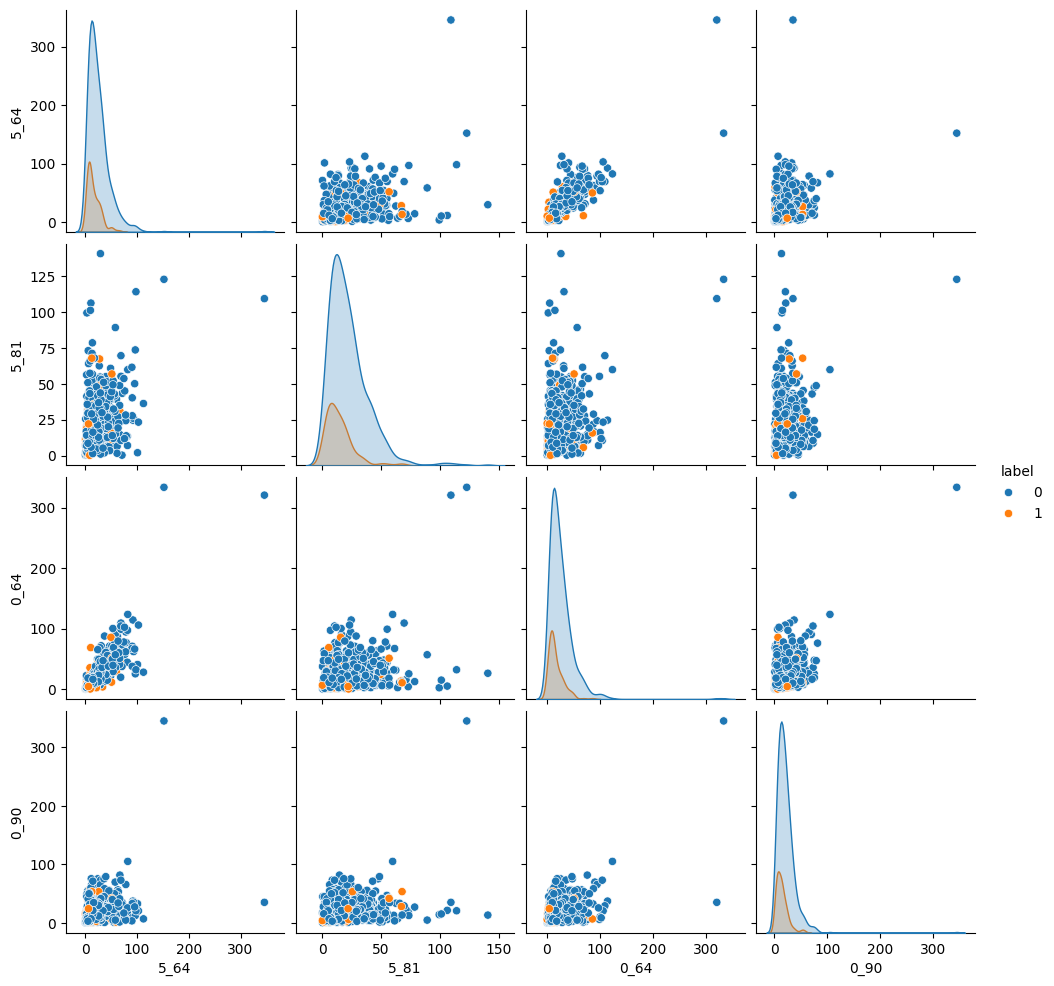

In [ ]:
# significantly differently features
dict_p_values = dict()
for kolom in data_healthy.columns:
  p_value = ttest_ind(data_healthy[kolom],data_abnormal[kolom],equal_var=False)
  dict_p_values[kolom] = p_value[1]

dict_sorted_p_values = dict(sorted(dict_p_values.items(),key = lambda x:x[1]))
features_sorted = list(dict_sorted_p_values.keys())
p_values = np.array(list(dict_sorted_p_values.values()))

print(f'Without multiple testing correction, {sum(p_values< (0.05))} features significantly differ between the two classes (with bonferroni correction {sum(p_values< (0.05/9000))})')


most_sign_data = data[features_sorted[:4] + ["label"]]
sns.pairplot(data = most_sign_data,hue = "label")

**Conclusions**:
*   Classes are imbalanced -> correction for class imbalance
*   Feature values are not normally distributed -> prevent parametric testing and use of mean value
*   Some samples are missing one ECG-lead -> imputation of samples
*   Different features have different values of different ranges -> normalisation
*   Data contains outliers -> no min-max normalisation and mean normalisation



## Train-test-split

Before further analysis, a train-test split will be performed

In [4]:
#Dividing the data in features (X) and labels (y)
X = data.copy()
X = X.drop('label',axis = 1)
y = data['label']

# Replacing the zeros (missing values with nan to enable imputation)
X.replace(0, np.nan, inplace=True)

#Performing a stratified train-test split
sss =  StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

train_index, test_index = next(sss.split(X, y))

#Selecting the training and testing samples
X_train = X.iloc[train_index]
X_test  = X.iloc[test_index]
y_train = y.iloc[train_index]
y_test  = y.iloc[test_index]


## Printing of the results
print(f'splitted in stratified train-test split with {len(X_train)} training samples and {len(X_train)} testing samples')
print(f'Trainset (n={len(X_train)}): {round(sum(y_train == 1)/(sum(y_train == 0)+   sum(y_train == 1)),3)*100}% of samples is abnormal')
print(f'Testset (n={len(X_test)}): {round(sum(y_test == 1)/(sum(y_test == 0)+ sum(y_test == 1)),3)*100}% of samples is abnormal')


splitted in stratified train-test split with 661 training samples and 661 testing samples
Trainset (n=661): 17.7% of samples is abnormal
Testset (n=166): 17.5% of samples is abnormal


## Preprocessing experiments

### Choosing scaling method

In [5]:
from sklearn import preprocessing

# standardscaler
scaler_st = preprocessing.StandardScaler()
scaler_st.fit(X_train)
X_train_st_scaled = pd.DataFrame(scaler_st.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_st_scaled = scaler_st.transform(X_test)

# smin max scaler
scaler_max = preprocessing.MinMaxScaler()
scaler_max.fit(X_train)
X_train_max_scaled = pd.DataFrame(scaler_max.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_max_scaled = scaler_max.transform(X_test)

# robust scaler
scaler_rob = preprocessing.RobustScaler()
scaler_rob.fit(X_train)
X_train_rob_scaled = pd.DataFrame(scaler_rob.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_rob_scaled = scaler_rob.transform(X_test)

# chose scaler is robust scaler
X_train_scaled = scaler_rob.transform(X_train)
X_test_scaled = scaler_rob.transform(X_test)

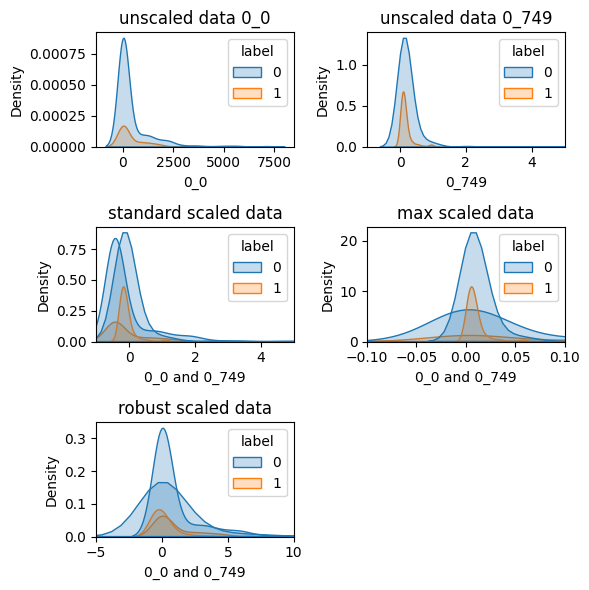

In [ ]:
# figures showing the scalers
fig, axs = plt.subplots(3,2,figsize = [6,6])

sns.kdeplot(data = X_train,x = '0_0',hue = y_train,fill = True, ax = axs[0,0])
axs[0,0].set(title = 'unscaled data 0_0')

sns.kdeplot(data = X_train,x = '0_749',hue = y_train,fill = True, ax = axs[0,1])
axs[0,1].set(title = 'unscaled data 0_749',
             xlim = [-1,5])

sns.kdeplot(data = X_train_st_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[1,0])
sns.kdeplot(data = X_train_st_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[1,0])
axs[1,0].set(title = 'standard scaled data',
             xlim = [-1,5],
             xlabel = '0_0 and 0_749')

sns.kdeplot(data = X_train_max_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[1,1])
sns.kdeplot(data = X_train_max_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[1,1])
axs[1,1].set(title = 'max scaled data',
             xlim = [-0.1,0.1],
             xlabel = '0_0 and 0_749')

sns.kdeplot(data = X_train_rob_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[2,0])
sns.kdeplot(data = X_train_rob_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[2,0])
axs[2,0].set(title = 'robust scaled data',
             xlim = [-5,10],
             xlabel = '0_0 and 0_749')

axs[2,1].remove()

plt.tight_layout()

Conclusions:
*   Minimum maximum scaler will not be used. When outliers are present such as in feature 0_0 we observe that distribution of feature 0_0 gets flattened. Inliers are cropped with the max scaler resulting in a deviated distribution from the original feature.
*   Robust scaler: scales the data with the IQR and median. It retains the distribution of the data especially when the distribution is not Gaussian. It is particularly useful when there is a non normal distribution.
*   Standard scaler: as there is a bit of skewness in the data of feature 0_0 we see when using the mean and standard deviation that the distribution shifts to the left. Because of outliers you can observe that the data inclines to the right (there data is not perfectly normal distributed). **When you are using standards scaled data, the mean is shifted towards the outliers and with robust scaling we don't have problems with this. **

Overall conclusions:
*   Robust scaler is preferred (other benefits: more stable and versatile)
*   Skewness is present (caused by outliers)


### Visualising imputation method

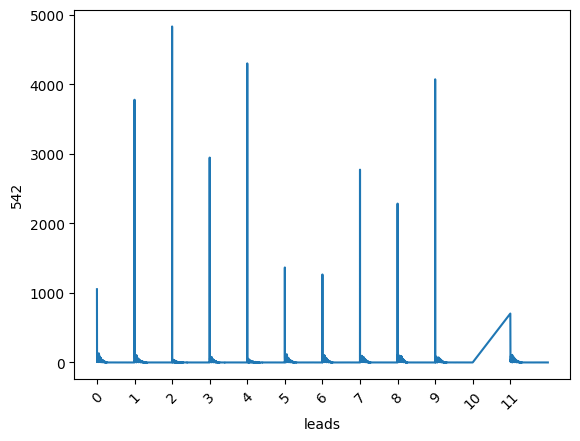

In [9]:
fig = plt.figure()
sns.lineplot(x = X_train.columns,y=X_train.loc[542,:])
plt.xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
plt.xlabel('leads')
plt.show()

In [13]:
 # Replacing the missing values with their median
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
imp_median.fit(X_train)
X_train_imputed = pd.DataFrame(imp_median.transform(X_train),columns = X_train.columns,index = X_train.index)

0


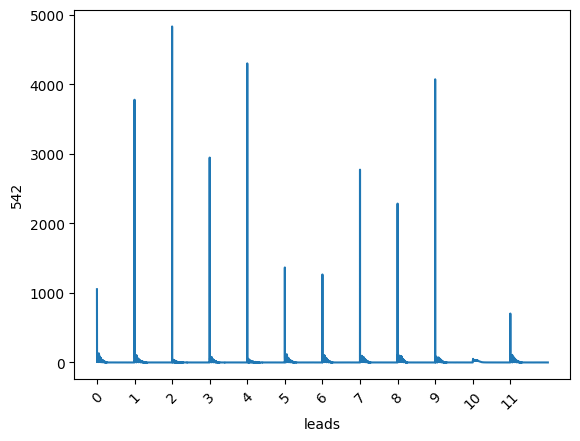

In [11]:
print((X_train_imputed.loc[542,:] == 0).sum())
fig = plt.figure()
sns.lineplot(x = X_train_imputed.columns,y=X_train_imputed.loc[542,:])
plt.xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
plt.xlabel('leads')
plt.show()

Conclusion:
The ranges of the features are large and differ. For this example, the other features have very high values, whilst a low value is imputed for the missing feature.

## Feature selection and extraction
We will perform feature selection because we observed the curse of dimensionality (9000 features). Our first goal is to reduce the number of features. We first chose other/simpler feature reduction techniques than PCA because PCA is hard to interpret by clinicians.


In [15]:
# Display the weights and compute error for multiple values for alpha
n_alphas = 15
alphas = np.logspace(-4, -1, n_alphas)
scores_lasso = []
n_features_lasso = []
features_lasso = {}
feature_names_lasso = {}

for alpha in alphas:
  lasso = Lasso(alpha = alpha,random_state = 1)
  # Define the pipeline
  pipeline = Pipeline([
       ('imputation',SimpleImputer(missing_values=np.nan,strategy = 'median')),
       ('scaling',RobustScaler()),
       ('selectmodel',SelectFromModel(lasso)),
       ('sampling',RandomOverSampler(random_state=1)),
       ('model', SVC(random_state=1)),
  ])

  # Define parameter grid for GridSearchCV
  param_grid = {
      'model__kernel': ['linear']
  }
  # Create GridSearchCV object
  grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5,verbose = 2,error_score='raise',scoring = 'f1')

  # Fit GridSearchCV to the training data
  grid_search.fit(X_train, y_train)

  # Print best parameters and best score
  print(f"Best parameters {alpha}:", grid_search.best_params_)
  print(f"Best score F1 {alpha}:", grid_search.best_score_)

  scores_lasso.append(grid_search.cv_results_['mean_test_score'])

    # Access the SelectFromModel transformer from the pipeline after fitting
  selectmodel = grid_search.best_estimator_.named_steps['selectmodel']
  selected_features_lasso = sum(selectmodel.get_support())
  n_features_lasso.append(selected_features_lasso)
  features_lasso[alpha] = X_train.loc[:,selectmodel.get_support()]


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.033e-01, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.735e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.234e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=  11.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.062e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0001: {'model__kernel': 'linear'}
Best score F1 0.0001: 0.4563754719242524
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.020e-01, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.811e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.034e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.106e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.587e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.093e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.00016378937069540646: {'model__kernel': 'linear'}
Best score F1 0.00016378937069540646: 0.4720634095634096
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.252e-01, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.378e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.121e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.391e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.355e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.750e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.00026826957952797245: {'model__kernel': 'linear'}
Best score F1 0.00026826957952797245: 0.45932588307427846
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.414e-01, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.383e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.849e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.565e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.369e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.00043939705607607906: {'model__kernel': 'linear'}
Best score F1 0.00043939705607607906: 0.458614149268624
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.473e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.364e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.162e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=  14.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0007196856730011522: {'model__kernel': 'linear'}
Best score F1 0.0007196856730011522: 0.45979676008745773
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.205e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0011787686347935866: {'model__kernel': 'linear'}
Best score F1 0.0011787686347935866: 0.48701298701298706
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.935e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.392e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.365e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0019306977288832496: {'model__kernel': 'linear'}
Best score F1 0.0019306977288832496: 0.5109172520616083
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.780e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.274e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.379e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.429e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.580e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0031622776601683794: {'model__kernel': 'linear'}
Best score F1 0.0031622776601683794: 0.478841219159382
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.501e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.640e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.005179474679231213: {'model__kernel': 'linear'}
Best score F1 0.005179474679231213: 0.5018127608825284
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.008483428982440717: {'model__kernel': 'linear'}
Best score F1 0.008483428982440717: 0.5169092922581295
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.592e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.831e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.605e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.958e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.754e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.013894954943731374: {'model__kernel': 'linear'}
Best score F1 0.013894954943731374: 0.48108668504512153
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.734e-02, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   8.0s
[CV] END ...............................model__kernel=linear; total time=   6.8s
[CV] END ...............................model__kernel=linear; total time=   7.5s
[CV] END ...............................model__kernel=linear; total time=   8.8s
[CV] END ...............................model__kernel=linear; total time=   9.5s
Best parameters 0.022758459260747887: {'model__kernel': 'linear'}
Best score F1 0.022758459260747887: 0.3972898550724637
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...............................model__kernel=linear; total time=   4.2s
[CV] END ...............................model__kernel=linear; total time=   5.1s
[CV] END ...............................model__kernel=linear; total time=   4.6s
[CV] END ...............................model__kernel=linear; total time=   8.9s
[CV] END ...............................model__kernel=linear; total time=   4.1s
Best param

In [16]:
# Define the pipeline
pipeline = Pipeline([
    ('imputation',SimpleImputer(missing_values=np.nan,strategy = 'median')),
    ('scaling',RobustScaler()),
    ('reduce_dim', 'passthrough'),
    ('sampling',RandomOverSampler(random_state=1)),
    ('model', SVC()),
])

# Define parameter grid for GridSearchCV
param_grid = [{
    'reduce_dim': [SelectKBest()],
    'reduce_dim__k': [10,50,100,200,300,400,800,1500],
    'model__kernel': ['linear']
},
              {
    'reduce_dim': [KernelPCA(kernel = 'linear',random_state = 1)],
    'reduce_dim__n_components': [10,50,100,200,300,400,800,1500],
    'model__kernel': ['linear']

              }]
# Create GridSearchCV object with pipelina and 5-fold crossvalidation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5,verbose = 2,scoring = 'f1')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=10; total time=   8.0s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=10; total time=   4.8s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=10; total time=   8.0s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=10; total time=   5.2s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=10; total time=   7.7s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=50; total time=   5.9s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=50; total time=   3.3s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=50; total time=   4.7s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=50; total time=   3.2s
[CV] END model__kernel=linear, reduce_dim=SelectKBest(), reduce_dim__k=50; total time=   3.4s

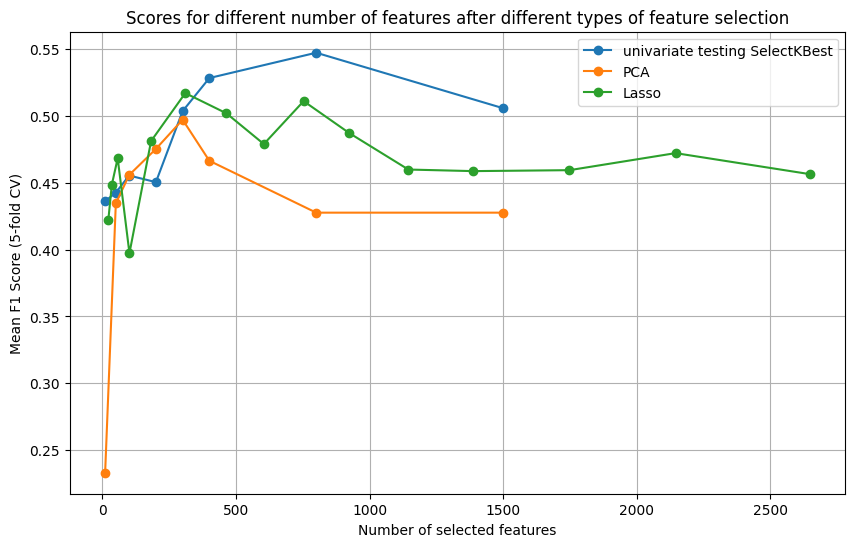

In [17]:
#Retrieve the number of features for each step
n_features_k = grid_search.cv_results_['param_reduce_dim__k'].compressed()
n_features_pca = grid_search.cv_results_['param_reduce_dim__n_components'].compressed()

#Collect the mean scores for each number of features
mean_test_scores = grid_search.cv_results_['mean_test_score']
mean_test_scores_k = mean_test_scores[:int((len(mean_test_scores)/2))]
mean_test_scores_pca = mean_test_scores[int((len(mean_test_scores)/2)):int(len(mean_test_scores))]

plt.figure(figsize=(10, 6))
plt.plot(n_features_k, mean_test_scores_k, marker='o', linestyle='-')
plt.plot(n_features_pca, mean_test_scores_pca, marker='o', linestyle='-')
plt.plot(n_features_lasso,scores_lasso,marker='o')

plt.title('Scores for different number of features after different types of feature selection')
plt.xlabel('Number of selected features')
plt.ylabel('Mean F1 Score (5-fold CV)')
plt.legend(['univariate testing SelectKBest','PCA','Lasso'])
plt.grid()
plt.show()

In [18]:
# Selecting the optimal alpha for the lasso feature selection
opt_n_features_lasso = n_features_lasso[scores_lasso.index(max(scores_lasso))]
opt_alpha_lasso = alphas[scores_lasso.index(max(scores_lasso))]


Conclusion based on grid search for two different feature selection techniques:
*  Lasso feature selection: the graph shows us that the top of the graph is reached between 500 and 1000 features. This amount of features have to be selected to get the optimal F1 score. This leads to the curse of dimensionality and overfitting.
*   Univariate testing: Each added feature contributes to an increment of the F1 score. Preferably, we would choose 800 features or more but this will lead to the curse of dimensionality.
*   PCA: the F1-score increases untill 200 features, after which the F1-score drops and stays constant. It seems like that using more features for the PCA does not give additional feature information.

As we found that 500-1000 features are preferable we are still faced with the curse of dimensionality because the number of features (500) is large comopared to the number of samples (827). Therefore we have the risk of overfitting (as we also saw in the learning curve). There are several methods of preventing overfitting. Besides, F1 score outperformed the PCA and is easier to explain individual features than a PCA. For this reason, Lasso features selection with 300 features will be used.

Other methods to mitigate the risk of overfitting when dealing with high-dimensional data, you can consider:

*   Feature Selection: Use techniques like feature selection to identify the most informative features and reduce the dimensionality of the feature space. (already done)
*   Cross-Validation: Use cross-validation to assess the generalization performance of the model and tune hyperparameters to prevent overfitting. (already done)
*   Dimensionality Reduction: Use dimensionality reduction techniques like Principal Component Analysis (PCA) or t-distributed Stochastic Neighbor Embedding (t-SNE) to project the data onto a lower-dimensional space while preserving as much variance as possible. (already done)
*   Regularization: Apply regularization techniques like L1 (Lasso) or L2 (Ridge) regularization to penalize large coefficients and prevent overfitting. (already done)
*   A combination of the aforementioned techniques (could still be executed)








## Classifiers

In [21]:
import time
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import RobustScaler

# Classifiers
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0)}

# Grids for grid search
KNN_grid = {'estimator__n_neighbors':[16,20,24,28,32,36],
            'estimator__weights': ['uniform','distance'],
            'estimator__metric': ['minkowski','euclidean','manhattan']}


SVC_grid = {'estimator__C': [50,10,0.1,0.01],
            'estimator__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'estimator__gamma': ['scale'],
            'estimator__degree': [2,3,4],  # degrees for polynomial kernel
            }

RF_grid = {'estimator__n_estimators': [50,100, 200, 300,500],
           'estimator__max_depth': [4, 8, 10, 12],
           'estimator__max_features': ['sqrt', 'log2']}


# Dictionary of all grids
grid = {
   "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid}


i=0
clf_best_params={}
clf_best_model={}

valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation F1 score': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()

    lasso = Lasso(alpha =  opt_alpha_lasso,random_state=1)

    #Pipeline containing preprocessing and classifier
    pipeline = Pipeline([
      ('imputation',SimpleImputer(missing_values=np.nan,strategy = 'median')),
      ('scaling',RobustScaler()),
      ('feature_selection',SelectFromModel(lasso)),
      ('sampling',RandomOverSampler(random_state=1)),
      ('estimator', classifier),
      ])

    clf = GridSearchCV(estimator=pipeline, param_grid=grid[key], cv=5,scoring = 'f1',verbose = 3)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.best_score_

    # Save trained model
    clf_best_params[key]=clf.best_params_
    clf_best_model[key] = clf.best_estimator_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)

    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.553 total time=  13.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.512 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.293 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.410 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.167 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=distance;, score=0.571 total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=distance;, score=0.500 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=distance;, score=0.444 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=distance;, score=0.390 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=16, estimator__weights=distance;, score=0.263 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.450 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.455 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.400 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.410 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.229 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=distance;, score=0.429 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=distance;, score=0.468 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=distance;, score=0.381 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=distance;, score=0.429 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=20, estimator__weights=distance;, score=0.263 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.455 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.439 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.400 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.359 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.324 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=distance;, score=0.522 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=distance;, score=0.444 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=distance;, score=0.381 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=distance;, score=0.350 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=24, estimator__weights=distance;, score=0.359 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.465 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.421 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.400 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.378 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.235 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=distance;, score=0.444 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=distance;, score=0.410 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=distance;, score=0.390 total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=distance;, score=0.400 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=28, estimator__weights=distance;, score=0.229 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.462 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.432 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.368 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.353 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.171 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=distance;, score=0.450 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=distance;, score=0.432 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=distance;, score=0.400 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=distance;, score=0.333 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=32, estimator__weights=distance;, score=0.171 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.421 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.333 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.270 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.188 total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.167 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=distance;, score=0.421 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=distance;, score=0.378 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=distance;, score=0.359 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=distance;, score=0.286 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=minkowski, estimator__n_neighbors=36, estimator__weights=distance;, score=0.162 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.553 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.512 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.293 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.410 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.167 total time=   6.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=distance;, score=0.571 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=distance;, score=0.500 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=distance;, score=0.444 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=distance;, score=0.390 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=16, estimator__weights=distance;, score=0.263 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.450 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.455 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.400 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.410 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.229 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=distance;, score=0.429 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=distance;, score=0.468 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=distance;, score=0.381 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=distance;, score=0.429 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=20, estimator__weights=distance;, score=0.263 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.455 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.439 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.400 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.359 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.324 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=distance;, score=0.522 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=distance;, score=0.444 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=distance;, score=0.381 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=distance;, score=0.350 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=24, estimator__weights=distance;, score=0.359 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.465 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.421 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.400 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.378 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.235 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=distance;, score=0.444 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=distance;, score=0.410 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=distance;, score=0.390 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=distance;, score=0.400 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=28, estimator__weights=distance;, score=0.229 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.462 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.432 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.368 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.353 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.171 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=distance;, score=0.450 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=distance;, score=0.432 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=distance;, score=0.400 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=distance;, score=0.333 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=32, estimator__weights=distance;, score=0.171 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.421 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.333 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.270 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.188 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.167 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=distance;, score=0.421 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=distance;, score=0.378 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=distance;, score=0.359 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=distance;, score=0.286 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=euclidean, estimator__n_neighbors=36, estimator__weights=distance;, score=0.162 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.450 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.364 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.182 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.308 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=uniform;, score=0.256 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=distance;, score=0.439 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=distance;, score=0.333 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=distance;, score=0.286 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=distance;, score=0.333 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=16, estimator__weights=distance;, score=0.300 total time=   7.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.333 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.353 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.188 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.364 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=uniform;, score=0.294 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=distance;, score=0.400 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=distance;, score=0.400 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=distance;, score=0.182 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=distance;, score=0.308 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=20, estimator__weights=distance;, score=0.368 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.378 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.375 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.242 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.345 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=uniform;, score=0.294 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=distance;, score=0.410 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=distance;, score=0.353 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=distance;, score=0.242 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=distance;, score=0.333 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=24, estimator__weights=distance;, score=0.333 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.343 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.323 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.250 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.333 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=uniform;, score=0.242 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=distance;, score=0.316 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=distance;, score=0.323 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=distance;, score=0.250 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=distance;, score=0.333 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=28, estimator__weights=distance;, score=0.294 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.294 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.286 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.138 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.333 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=uniform;, score=0.258 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=distance;, score=0.343 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=distance;, score=0.333 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=distance;, score=0.194 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=distance;, score=0.364 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=32, estimator__weights=distance;, score=0.250 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.294 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.267 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.200 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.222 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=uniform;, score=0.267 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=distance;, score=0.294 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=distance;, score=0.267 total time=   7.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=distance;, score=0.200 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=distance;, score=0.276 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__metric=manhattan, estimator__n_neighbors=36, estimator__weights=distance;, score=0.375 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Model: KNN
Training time (mins): 24.1

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.634 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.474 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.465 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.550 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.424 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.462 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.421 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.353 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.312 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.214 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.257 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.394 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.296 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.444 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.500 total time=   7.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.634 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.474 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.465 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.550 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.424 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.194 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.250 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.312 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.143 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.071 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.257 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.394 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.296 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.444 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.500 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.634 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.474 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.465 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.550 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.424 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.071 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.258 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.214 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.143 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.138 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.257 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.394 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.296 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.444 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=50, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.500 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   7.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.591 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.389 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.488 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.558 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.424 total time=   7.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.250 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.343 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.324 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.207 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.148 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.257 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.394 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.296 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.456 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.258 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.591 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.389 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.488 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.558 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.424 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.074 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.200 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.207 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.143 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.143 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.257 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.394 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.296 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.456 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.258 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.591 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.389 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.488 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.558 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.424 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.267 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.148 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.071 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.138 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.257 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.394 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.296 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.456 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=10, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.258 total time=  12.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.229 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.359 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.244 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.235 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.368 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.154 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.080 total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.148 total time=  15.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.077 total time=  15.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.258 total time=  13.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.129 total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.129 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.250 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.229 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.359 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.244 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.235 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.368 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.154 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.148 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.077 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.258 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.129 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.129 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.250 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.524 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.558 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.229 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.359 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.244 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.235 total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.368 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.154 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.148 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.077 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.258 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.129 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.129 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.1, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.250 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.537 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.585 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.129 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.235 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.200 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.065 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=rbf;, score=0.286 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=poly;, score=0.077 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.077 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.286 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.133 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.069 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=2, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.200 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.537 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.585 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.129 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.235 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.200 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.065 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=rbf;, score=0.286 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=poly;, score=0.077 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.077 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.286 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.133 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.069 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=3, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.200 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.591 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.537 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.455 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.585 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=linear;, score=0.457 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.129 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.235 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.200 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.065 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=rbf;, score=0.286 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.080 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.000 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=poly;, score=0.077 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.077 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.286 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.133 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.069 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__C=0.01, estimator__degree=4, estimator__gamma=scale, estimator__kernel=sigmoid;, score=0.200 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Model: SVC
Training time (mins): 35.51

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.550 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.514 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.300 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.651 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.316 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.476 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.571 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.326 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.553 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.410 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.524 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.611 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.300 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.476 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.389 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.537 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.611 total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.293 total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.489 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.400 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.500 total time=  11.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.571 total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.372 total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.524 total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.432 total time=  11.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=50;, score=0.550 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=50;, score=0.632 total time=   7.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=50;, score=0.211 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=50;, score=0.500 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=50;, score=0.421 total time=   7.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=100;, score=0.500 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=100;, score=0.615 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=100;, score=0.211 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=100;, score=0.488 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=100;, score=0.389 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=200;, score=0.474 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=200;, score=0.571 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=200;, score=0.211 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=200;, score=0.524 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=200;, score=0.400 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=300;, score=0.474 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=300;, score=0.571 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=300;, score=0.263 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=300;, score=0.488 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=300;, score=0.421 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=500;, score=0.500 total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=500;, score=0.571 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=500;, score=0.286 total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=500;, score=0.513 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=4, estimator__max_features=log2, estimator__n_estimators=500;, score=0.389 total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.400 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.467 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.071 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.414 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.333 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.345 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.467 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.143 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.452 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.333 total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.214 total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.414 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.148 total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.400 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.387 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.333 total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.414 total time=  15.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.148 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.400 total time=  11.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.333 total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.333 total time=  13.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.414 total time=  12.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.154 total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.400 total time=  12.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.333 total time=  12.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=50;, score=0.345 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=50;, score=0.345 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=50;, score=0.154 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=50;, score=0.467 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=50;, score=0.312 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=100;, score=0.286 total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=100;, score=0.357 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=100;, score=0.083 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=100;, score=0.357 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=100;, score=0.345 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=200;, score=0.222 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=200;, score=0.357 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=200;, score=0.080 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=200;, score=0.345 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=200;, score=0.345 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=300;, score=0.286 total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=300;, score=0.357 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=300;, score=0.080 total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=300;, score=0.345 total time=  10.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=300;, score=0.286 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=500;, score=0.286 total time=  11.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=500;, score=0.357 total time=  11.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=500;, score=0.160 total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=500;, score=0.400 total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=8, estimator__max_features=log2, estimator__n_estimators=500;, score=0.345 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.452 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.452 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.160 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.467 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.286 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.345 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.452 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.154 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.452 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.286 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.345 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.467 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.160 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.452 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.345 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.345 total time=  11.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.467 total time=  11.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.160 total time=  11.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.452 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.286 total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.286 total time=  13.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.467 total time=  12.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.154 total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.452 total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.345 total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=50;, score=0.345 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=50;, score=0.467 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=50;, score=0.143 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=50;, score=0.357 total time=   8.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=50;, score=0.286 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=100;, score=0.286 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=100;, score=0.357 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=100;, score=0.074 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=100;, score=0.357 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=100;, score=0.400 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=200;, score=0.286 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=200;, score=0.357 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=200;, score=0.160 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=200;, score=0.345 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=200;, score=0.345 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=300;, score=0.222 total time=  10.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=300;, score=0.357 total time=  10.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=300;, score=0.160 total time=   9.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=300;, score=0.286 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=300;, score=0.286 total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=500;, score=0.222 total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=500;, score=0.357 total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=500;, score=0.160 total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=500;, score=0.345 total time=  11.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=10, estimator__max_features=log2, estimator__n_estimators=500;, score=0.345 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.400 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.414 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.083 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.400 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=50;, score=0.222 total time=   9.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.345 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.467 total time=   8.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.160 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.500 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=100;, score=0.286 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.286 total time=  10.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.414 total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.160 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.452 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=200;, score=0.286 total time=   9.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.222 total time=  11.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.414 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.160 total time=  11.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.452 total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=300;, score=0.286 total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.222 total time=  13.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.414 total time=  12.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.154 total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.452 total time=  12.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=sqrt, estimator__n_estimators=500;, score=0.286 total time=  13.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=50;, score=0.222 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=50;, score=0.296 total time=   8.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=50;, score=0.083 total time=   7.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=50;, score=0.286 total time=   8.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=50;, score=0.276 total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=100;, score=0.154 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=100;, score=0.357 total time=   8.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=100;, score=0.083 total time=   8.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=100;, score=0.296 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=100;, score=0.345 total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=200;, score=0.222 total time=   9.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=200;, score=0.357 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=200;, score=0.083 total time=   8.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=200;, score=0.357 total time=   9.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=200;, score=0.345 total time=   9.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=300;, score=0.222 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=300;, score=0.357 total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=300;, score=0.083 total time=   9.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=300;, score=0.357 total time=  10.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=300;, score=0.345 total time=   9.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=500;, score=0.154 total time=  11.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=500;, score=0.357 total time=  10.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=500;, score=0.083 total time=  10.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=500;, score=0.400 total time=  10.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END estimator__max_depth=12, estimator__max_features=log2, estimator__n_estimators=500;, score=0.286 total time=  11.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Model: RandomForest
Training time (mins): 32.96



In [22]:
valid_scores

,Classifer,Validation F1 score,Training time
0,KNN,0.433855,24.10
1,SVC,0.524910,35.51
2,RandomForest,0.479953,32.96


In [23]:
clf_best_params

{'KNN': {'estimator__metric': 'minkowski',
  'estimator__n_neighbors': 16,
  'estimator__weights': 'distance'},
 'SVC': {'estimator__C': 0.01,
  'estimator__degree': 2,
  'estimator__gamma': 'scale',
  'estimator__kernel': 'linear'},
 'RandomForest': {'estimator__max_depth': 4,
  'estimator__max_features': 'sqrt',
  'estimator__n_estimators': 500}}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e-01, tolerance: 9.231e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.393e-01, tolerance: 1.619e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.504e-01, tolerance: 2.492e

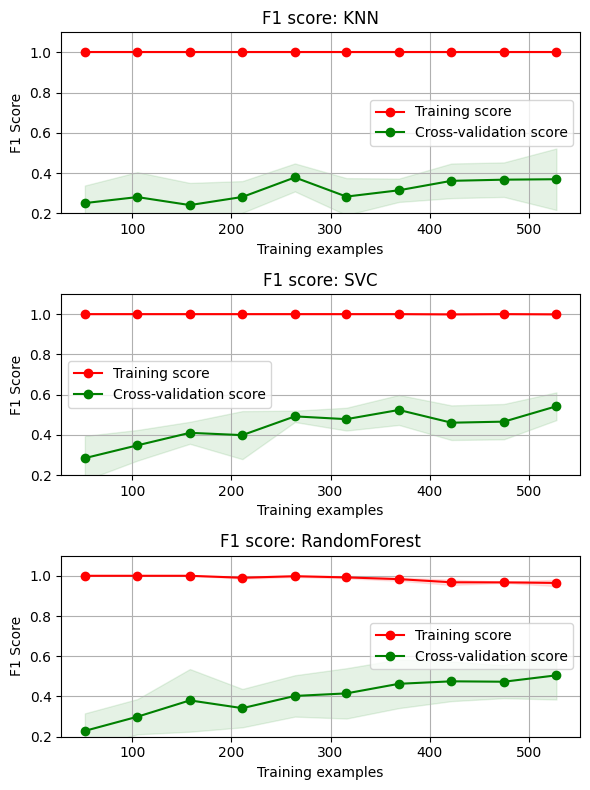

In [25]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("F1 Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,scoring = 'f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

  # Now use the classifiers on all datasets
num = 0
fig = plt.figure(figsize=(6,8))
for key, clf in clf_best_model.items():
      # Split data in training and testing
      feature_lasso = features_lasso[alpha]
      title = f'F1 score: {key}'
      ax = fig.add_subplot(3, 1, num + 1)
      plot_learning_curve(clf, title, X_train, y_train, ax, ylim=(0.2, 1.1), cv=5)
      num += 1
plt.tight_layout()
fig.show()


### Experiments to improve the validation performance

In [40]:
pipeline_samp= Pipeline([
      ('imputation',SimpleImputer(missing_values=np.nan,strategy = 'median')),
      ('scaling',RobustScaler()),
      ('feature_selection',SelectFromModel(lasso)),
      ('sampling',RandomOverSampler(random_state=1)),
      ('estimator', SVC(C=0.01, degree=2, kernel='linear', probability=True,
                      random_state=0))
      ])

pipeline_penalise = Pipeline([
      ('imputation',SimpleImputer(missing_values=np.nan,strategy = 'median')),
      ('scaling',RobustScaler()),
      ('feature_selection',SelectFromModel(lasso)),
      ('estimator', SVC(C=0.01, degree=2, kernel='linear', probability=True,
                      random_state=0,class_weight= 'balanced'))
      ])

f1 = make_scorer(f1_score)
cv = StratifiedKFold(n_splits = 5)

output_samp = cross_val_score(pipeline_samp,X_train,y_train,cv = cv,scoring = f1)
output_penalise = cross_val_score(pipeline_penalise,X_train,y_train,cv = cv,scoring = f1)

print(output_samp.mean())
print(output_penalise.mean())





/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 7.730e

0.5249097244219196
0.5346658219828953


## Applying on test set

In [45]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

#Retrieving the pipeline previously optimised with the validation dataset
pipeline_svc = clf_best_model['SVC']


#Fitting this pipeline on the full design set
pipeline_svc.fit(X_train,y_train)

y_pred = pipeline_svc.predict(X_test)
# accuracy
accuracy = (accuracy_score(y_test,y_pred))
f_score = (f1_score(y_test,y_pred))
print(f'F1-score: {f1_score(y_test,y_pred):.3f}')
print(f'accuracy score: {accuracy_score(y_test,y_pred):.3f}')



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.357e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


F1-score: 0.462
accuracy score: 0.831


Confusion Matrix:
[[126  11]
 [ 17  12]]


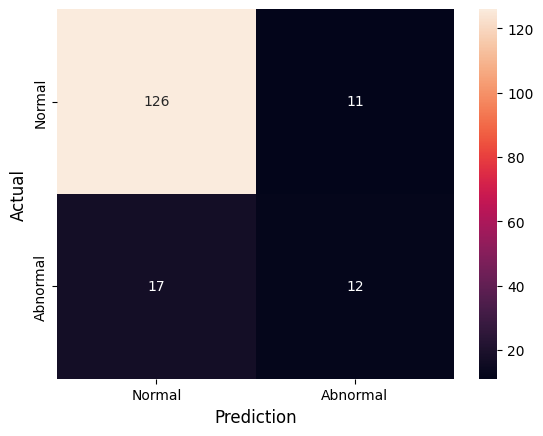

In [43]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# define and print matrix with labels
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Normal','Abnormal'],
            yticklabels=['Normal','Abnormal'])

# display matrix
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.show()

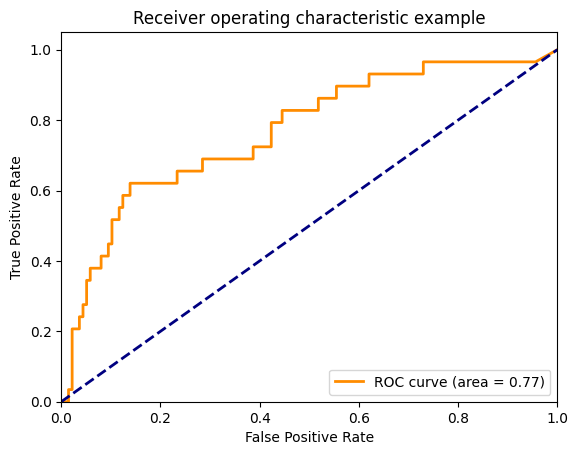

In [44]:
# Create ROC curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

y_proba = pipeline_svc.predict_proba(X_test)
plot_roc_curve(y_proba, y_test)